# Script to Look at Climatology of Oceanography for Southern California

In [1]:
#import standard packages
import datetime
from datetime import date
import logging
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser, Namespace
from functools import reduce
import glob
import matplotlib.patches as patches
import calendar

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import dask.dataframe as dd
import tqdm

#import spatial packages
import geopandas as gpd
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rio
import seaborn as sns
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
import flox.xarray

#import statistical packages
import statsmodels.api as sm
from scipy.stats import linregress
from shapely.geometry import Point, mapping
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

from pqdm.threads import pqdm
from eosdis_store import EosdisStore
import requests
import tqdm

### SST

In [36]:
sst = xr.open_dataset('/Users/gammonkoval/Documents/LargeData/OISST/sst.mon.mean.nc')
sst.close()

sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180
sst = sst.sortby(sst.lon)


sst = sst.sel(lat = slice(30, 40), lon = slice(-126, -116), time = slice('1982-01-01', '2023-12-31'))
sst = sst.sel(lat = slice(31, 35), lon = slice(-122, -116))

In [142]:
files = glob.glob('/Users/gammonkoval/Downloads/bd695b6f5d73ee19e29ca5ad2ddf6cb7/*.nc')

era5 = xr.open_mfdataset(files)

era5 = era5.sel(longitude = slice(-122.5, -116.5))
era5

<xarray.Dataset>
Dimensions:     (valid_time: 740, latitude: 21, longitude: 25)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1994-01-01 ... 2024-10-01T06:00:00
  * latitude    (latitude) float64 31.0 31.25 31.5 31.75 ... 35.5 35.75 36.0
  * longitude   (longitude) float64 -122.5 -122.2 -122.0 ... -116.8 -116.5
    number      int64 0
    expver      (valid_time) object dask.array<chunksize=(370,), meta=np.ndarray>
Data variables:
    sst         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
    msl         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
    swh         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 11, 13), meta=np.ndarray>
    mwd         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 11, 13), meta=np.ndarray>
    mwp         (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 11, 13), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(370, 21, 25), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

<Figure size 1000x2000 with 0 Axes>

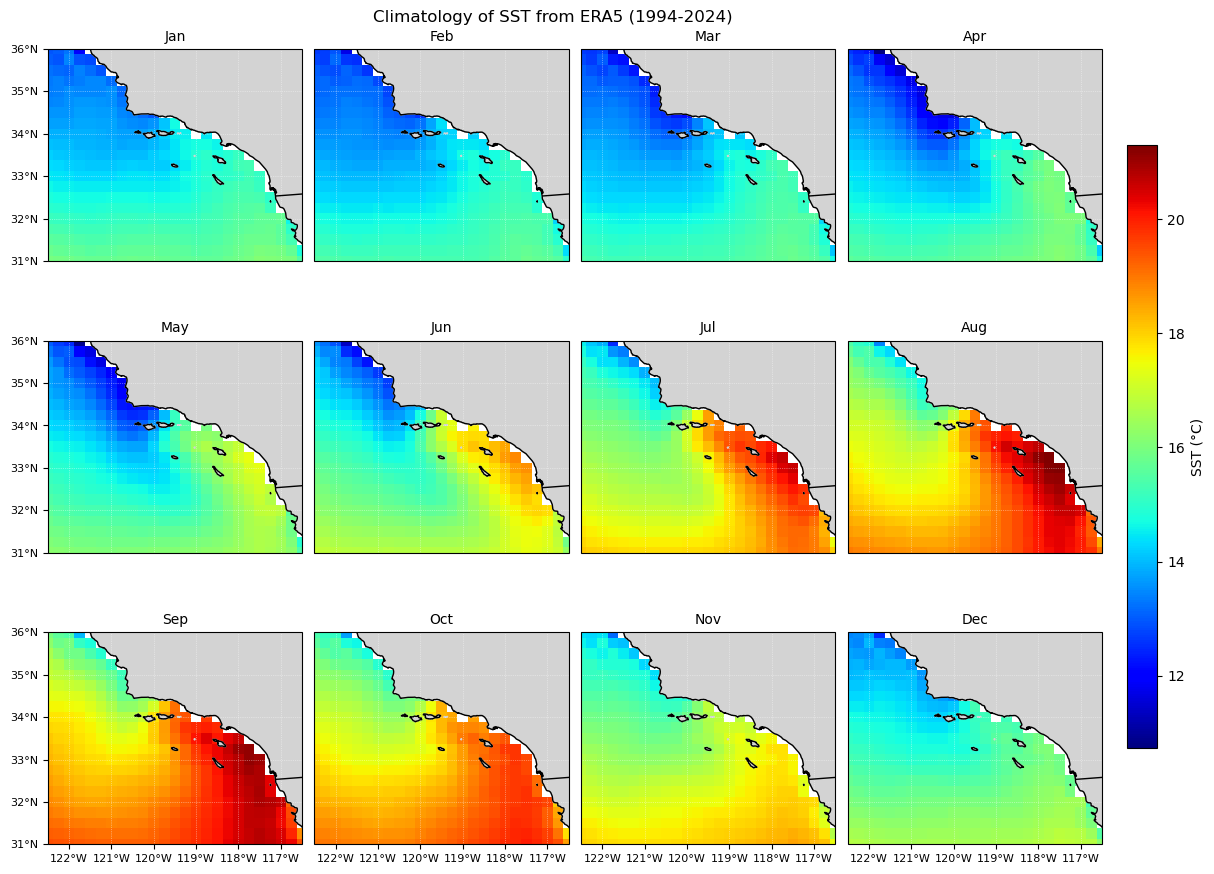

In [143]:
plt.figure(figsize = (10, 20))

p = era5.groupby(era5.valid_time.dt.month).mean()
p['sst'] = p['sst'] - 273.15
p = p.sst.plot(
    transform=ccrs.PlateCarree(),
    col="month", col_wrap = 4, cmap = 'jet',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={'label':'SST (°C)', 'shrink':0.7, 'pad':0.02}
)

#add in coastlines and set the title for each month
for i, axs in zip(range(12), p.axes.flat):
    # Create and set the figure context
    axs.coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    axs.add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs.add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs.set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs.set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs.set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs.set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    
    axs.set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs.gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    # axs.set_aspect('equal')
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    axs.set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

# plt.tight_layout()
# plt.subplots_adjust(wspace = 0.2, hspace = -0.4)

# cbar_cax = [1, 0, 
# cb_ax = axs.add_axes([.91, .124, .04, .754])
# plt.colorbar(p,orientation='vertical',cax=cb_ax)

plt.suptitle('Climatology of SST from ERA5 (1994-2024)', x = 0.4)
plt.show()

<Figure size 1000x2000 with 0 Axes>

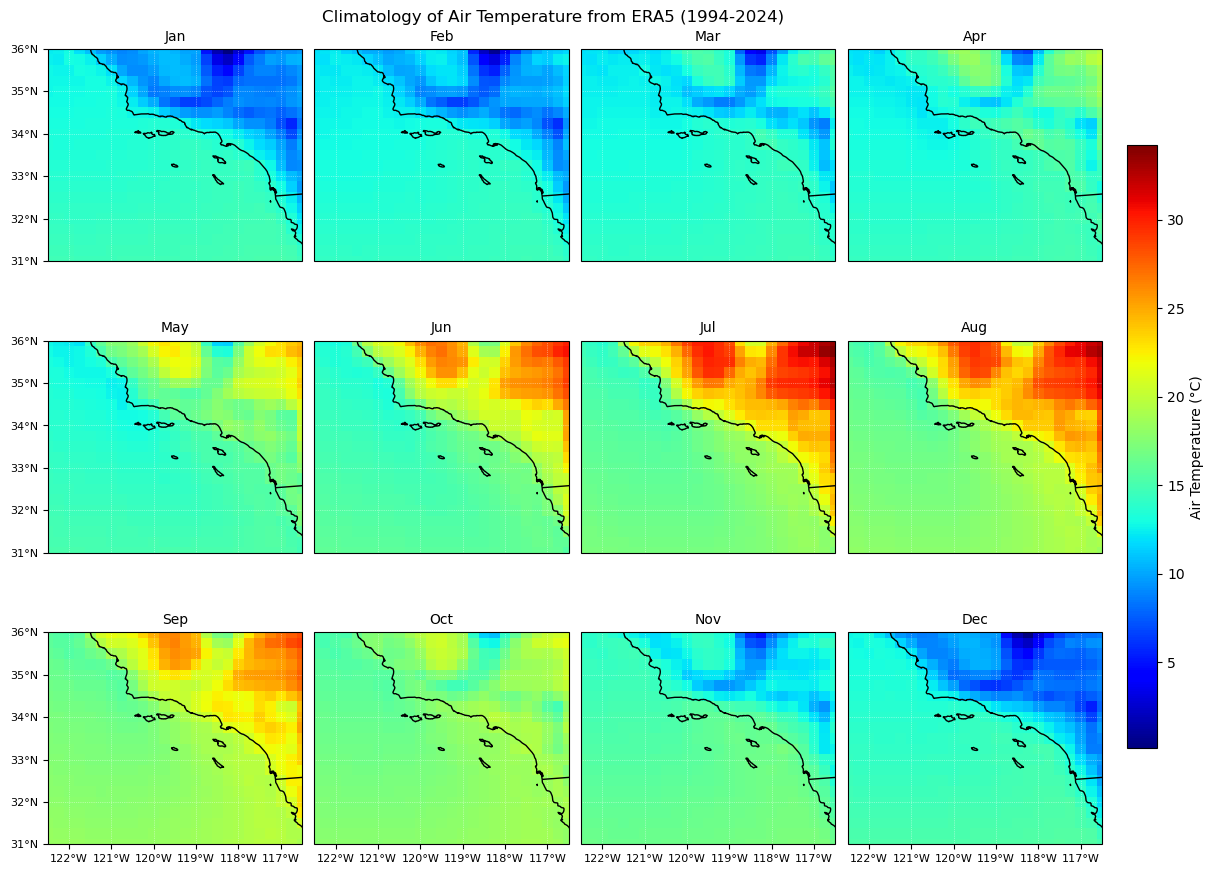

In [191]:
plt.figure(figsize = (10, 20))

p = era5.groupby(era5.valid_time.dt.month).mean()
p['t2m'] = p['t2m'] - 273.15
p = p.t2m.plot(
    transform=ccrs.PlateCarree(),
    col="month", col_wrap = 4, cmap = 'jet',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={'label':'Air Temperature (°C)', 'shrink':0.7, 'pad':0.02}
)

#add in coastlines and set the title for each month
for i, axs in zip(range(12), p.axes.flat):
    # Create and set the figure context
    axs.coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    # axs.add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs.add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs.set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs.set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs.set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs.set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    
    axs.set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs.gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    # axs.set_aspect('equal')
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    axs.set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

# plt.tight_layout()
# plt.subplots_adjust(wspace = 0.2, hspace = -0.4)

# cbar_cax = [1, 0, 
# cb_ax = axs.add_axes([.91, .124, .04, .754])
# plt.colorbar(p,orientation='vertical',cax=cb_ax)

plt.suptitle('Climatology of Air Temperature from ERA5 (1994-2024)', x = 0.4)
plt.show()

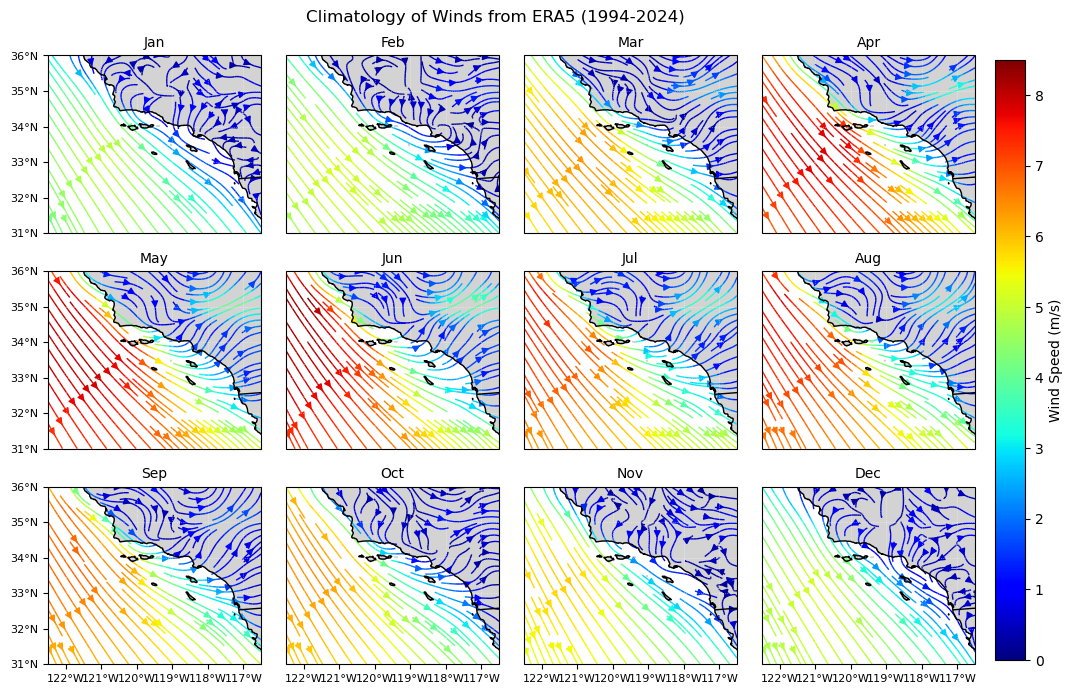

In [190]:

# p = era5.groupby(era5.valid_time.dt.month).mean().plot.streamplot(
#     x = 'longitude', y = 'latitude', u = 'u10', v = 'v10',
#     # transform=ccrs.PlateCarree(),
#     col="month", col_wrap = 4, cmap = 'jet',
#     subplot_kws={"projection": ccrs.PlateCarree()},
#     cbar_kwargs={'label':'SST (°C)', 'shrink':0.7, 'pad':0.02}
# )

fig, ax = plt.subplots(3, 4, sharex = True, sharey = True, figsize = (10, 10),
                      subplot_kw={'projection': ccrs.PlateCarree()},)

axs = ax.flatten()

#add in coastlines and set the title for each month
for i in range(12):
    # Create and set the figure context
    axs[i].coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    axs[i].add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs[i].add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs[i].set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs[i].set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs[i].set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs[i].set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs[i].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs[i].yaxis.set_major_formatter(LatitudeFormatter())
    
    axs[i].set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs[i].gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    p = era5.groupby(era5.valid_time.dt.month).mean().isel(month = i)
    p['wind_spd'] = np.sqrt(p.u10**2 + p.v10**2)
    norm = mpl.colors.Normalize(vmin=0, vmax=8.5)
    # p = p.plot.streamplot(ax = axs[i], density = 2, color = p.wind_spd.values,
    # x = 'longitude', y = 'latitude', u = 'u10', v = 'v10', cmap = 'jet', norm = norm)
    strm = axs[i].streamplot(x=p["longitude"],y=p["latitude"], u=p["u10"], v=p["v10"], color=p.wind_spd.values, linewidth=1, cmap='jet', density=1, norm=norm)

    # axs.set_aspect('equal')
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

plt.tight_layout()
plt.subplots_adjust(hspace = -0.6)

cb_ax = fig.add_axes([1, .2, .03, .6])
plt.colorbar(strm.lines,orientation='vertical',cax=cb_ax, label = 'Wind Speed (m/s)')#, min= 0, vmax = 8.5)

plt.suptitle('Climatology of Winds from ERA5 (1994-2024)', y = 0.85)
plt.show()

<Figure size 1000x2000 with 0 Axes>

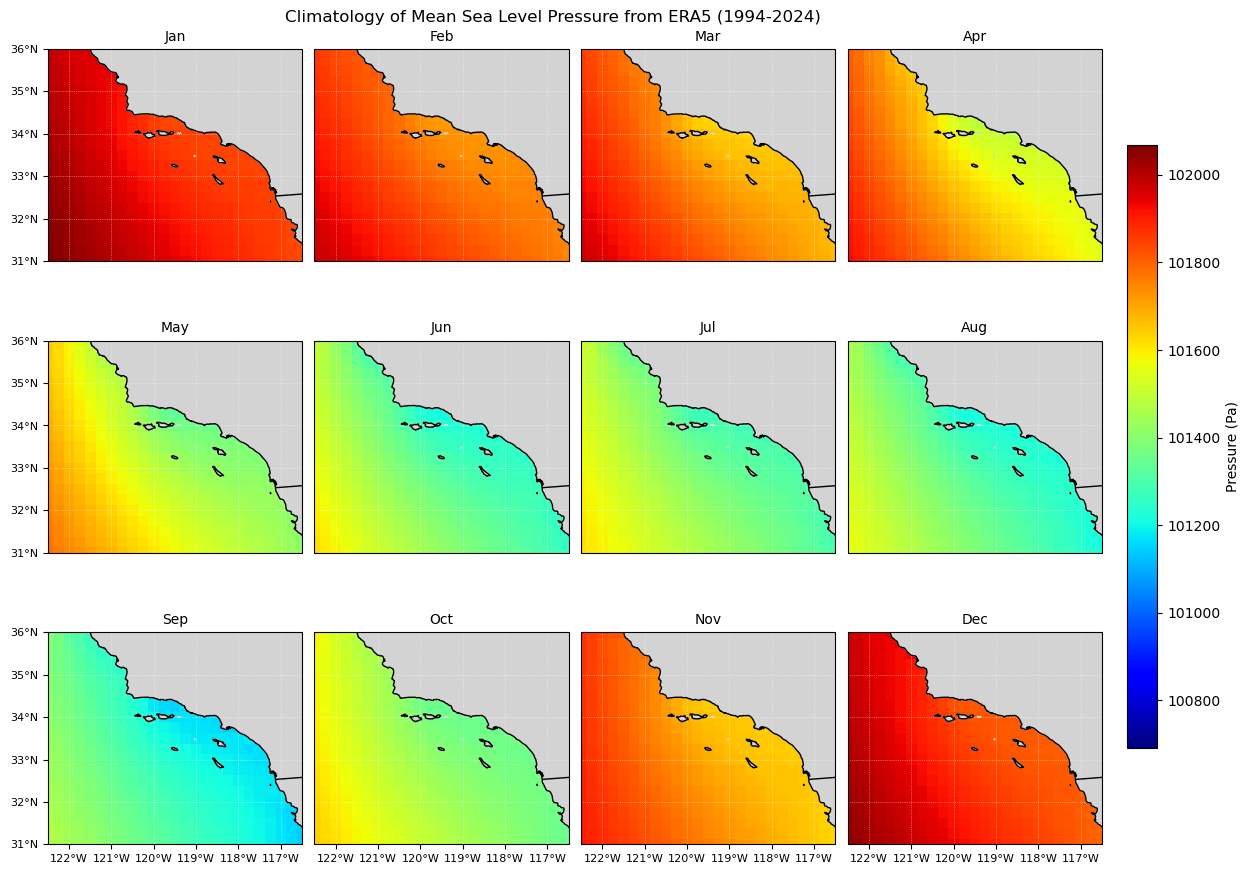

In [150]:
plt.figure(figsize = (10, 20))

p = era5.groupby(era5.valid_time.dt.month).mean().msl.plot(
    transform=ccrs.PlateCarree(),
    col="month", col_wrap = 4, cmap = 'jet',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={'label':'Pressure (Pa)', 'shrink':0.7, 'pad':0.02}
)

#add in coastlines and set the title for each month
for i, axs in zip(range(12), p.axes.flat):
    # Create and set the figure context
    axs.coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    axs.add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs.add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs.set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs.set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs.set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs.set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    
    axs.set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs.gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    # axs.set_aspect('equal')
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    axs.set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

# plt.tight_layout()
# plt.subplots_adjust(wspace = 0.2, hspace = -0.4)

# cbar_cax = [1, 0, 
# cb_ax = axs.add_axes([.91, .124, .04, .754])
# plt.colorbar(p,orientation='vertical',cax=cb_ax)

plt.suptitle('Climatology of Mean Sea Level Pressure from ERA5 (1994-2024)', x = 0.4)
plt.show()

<Figure size 1000x2000 with 0 Axes>

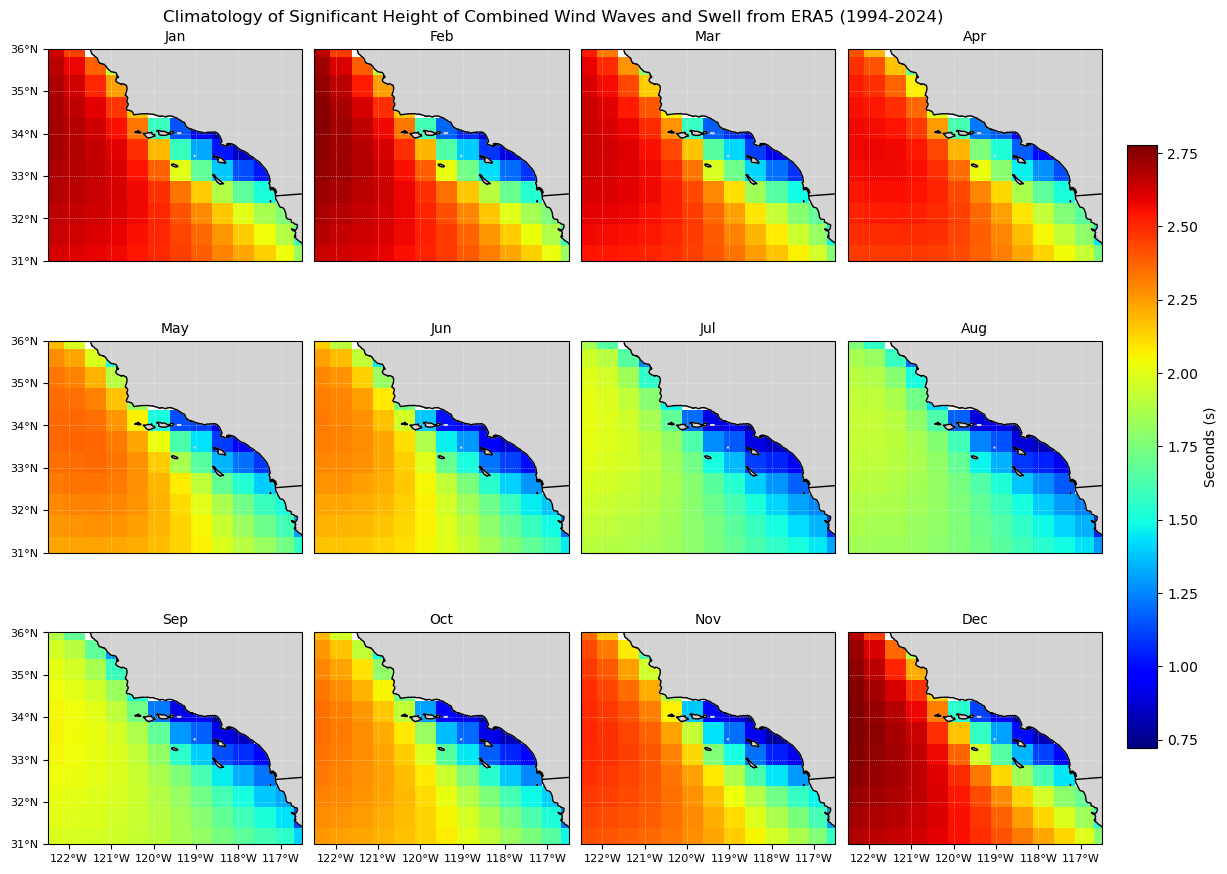

In [151]:
plt.figure(figsize = (10, 20))

p = era5.coarsen(latitude = 2, longitude = 2, boundary = 'pad').mean().groupby(era5.valid_time.dt.month).mean().swh.plot(
    transform=ccrs.PlateCarree(),
    col="month", col_wrap = 4, cmap = 'jet',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={'label':'Seconds (s)', 'shrink':0.7, 'pad':0.02}
)

#add in coastlines and set the title for each month
for i, axs in zip(range(12), p.axes.flat):
    # Create and set the figure context
    axs.coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    axs.add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs.add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs.set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs.set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs.set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs.set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    
    axs.set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs.gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    # axs.set_aspect('equal')
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    axs.set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

# plt.tight_layout()
# plt.subplots_adjust(wspace = 0.2, hspace = -0.4)

# cbar_cax = [1, 0, 
# cb_ax = axs.add_axes([.91, .124, .04, .754])
# plt.colorbar(p,orientation='vertical',cax=cb_ax)

plt.suptitle('Climatology of Significant Height of Combined Wind Waves and Swell from ERA5 (1994-2024)', x = 0.4)
plt.show()

<Figure size 1000x2000 with 0 Axes>

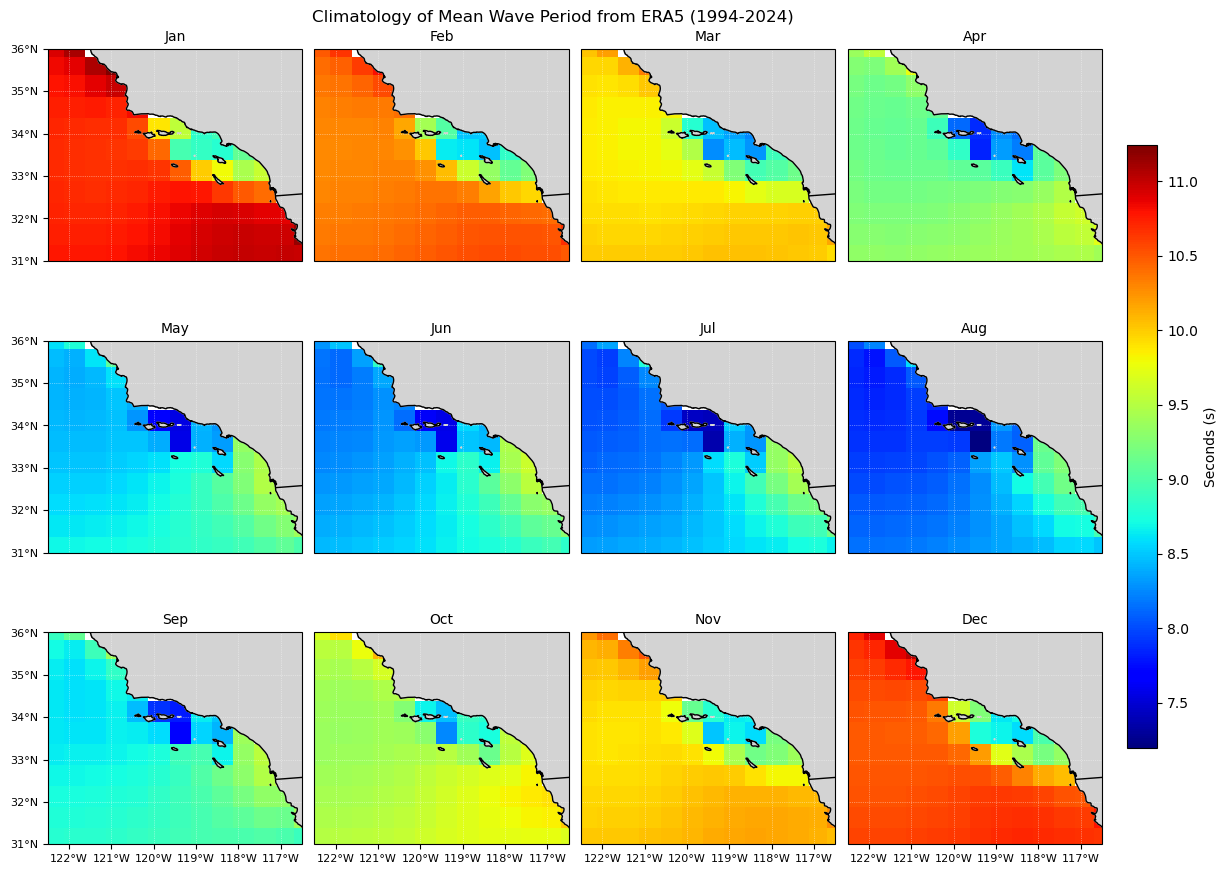

In [154]:
plt.figure(figsize = (10, 20))

p = era5.coarsen(latitude = 2, longitude = 2, boundary = 'pad').mean().groupby(era5.valid_time.dt.month).mean().mwp.plot(
    transform=ccrs.PlateCarree(),
    col="month", col_wrap = 4, cmap = 'jet',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={'label':'Seconds (s)', 'shrink':0.7, 'pad':0.02}
)

#add in coastlines and set the title for each month
for i, axs in zip(range(12), p.axes.flat):
    # Create and set the figure context
    axs.coastlines(resolution='10m',linewidth=1,color='black', zorder = 4) 
    axs.add_feature(cfeature.LAND, color='lightgrey', alpha=1, zorder = 1)
    axs.add_feature(cfeature.BORDERS, zorder = 3)

    if i >= 8:
        axs.set_xticks(np.round([*np.arange(-180, 180, 1)]), crs=ccrs.PlateCarree())
        axs.set_xticklabels(np.round([*np.arange(-180, 180, 1)]), fontsize=8)  
    
    if i in [0, 4, 8]:
        axs.set_yticks(np.round([*np.arange(-90, 90, 1)]), crs=ccrs.PlateCarree()) 
        axs.set_yticklabels(np.round([*np.arange(-90, 90, 1)]), fontsize=8)  
        
    axs.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    axs.yaxis.set_major_formatter(LatitudeFormatter())
    
    axs.set_extent([era5.longitude.min(), era5.longitude.max(), era5.latitude.min(), era5.latitude.max()], crs=ccrs.PlateCarree()) 
    axs.gridlines(linestyle = 'dotted', linewidth = 0.5, color = 'white', alpha = 0.7)

    # axs.set_aspect('equal')
    axs.set_xlabel(None)
    axs.set_ylabel(None)
    axs.set_title(calendar.month_abbr[int(sst.isel(time = i).time.dt.month.values)], fontsize = 10)

# plt.tight_layout()
# plt.subplots_adjust(wspace = 0.2, hspace = -0.4)

# cbar_cax = [1, 0, 
# cb_ax = axs.add_axes([.91, .124, .04, .754])
# plt.colorbar(p,orientation='vertical',cax=cb_ax)

plt.suptitle('Climatology of Mean Wave Period from ERA5 (1994-2024)', x = 0.4)
plt.show()